##  Калибровка моделей на данные

In [1]:
import pandas as pd 
import numpy as np
data = pd.read_csv('Лекция 6 dataset.csv',header=None)
data.columns = ['time', 'value']

In [2]:
data.value = [float(x.replace(',', '.')) for x in data.value]
data.head()

,time,value
0,1,35.834888
1,2,34.315693
2,3,34.736127
3,4,34.989171
4,5,32.166988


<AxesSubplot:xlabel='time', ylabel='value'>

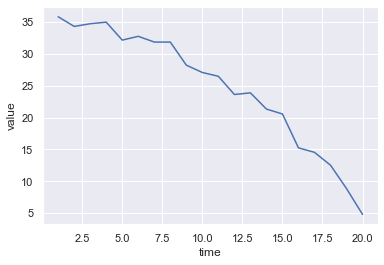

In [3]:
import seaborn as sns 
sns.set()
sns.lineplot(data=data, x="time", y="value")

Для калибровки экспоненциальной модели воспользуемся методом `curve_fit` из библиотеки `scipy.optimize`. 

In [4]:
import math

In [5]:
def exponentialmodel(x, a, b, c):
     return a*np.exp(b*x)+c

In [6]:
from scipy.optimize import curve_fit

In [7]:
coeff,_ = curve_fit(exponentialmodel, data.time.values, data.value.values)

In [8]:
expy = exponentialmodel(data.time, *coeff)

<AxesSubplot:xlabel='time', ylabel='value'>

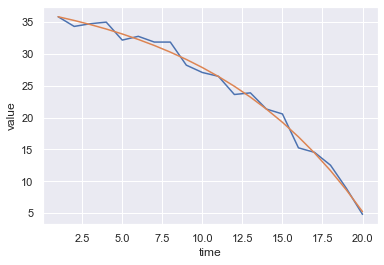

In [9]:
sns.lineplot(data=data, x="time", y="value") 
sns.lineplot(x=data.time, y=expy)

In [10]:
from sklearn.metrics import r2_score

In [11]:
print(f'Полученные коффициенты a = {coeff[0]}, b = {coeff[1]}, c = {coeff[2]}')
print(f'R2 = {r2_score(data.value, expy)}')

Полученные коффициенты a = -5.107426942891683, b = 0.09797077811152141, c = 41.46556699262769
R2 = 0.9909813089205097


Создадим датафрейм для хранения результатов 

In [12]:
CalibrationResults = pd.DataFrame(columns=['Model', 'Coefficients', 'R2-score'])

In [13]:
CalibrationResults = CalibrationResults.append({'Model': 'Exponential', 
                           'Coefficients': f'a = {round(coeff[0], 3)}, b = {round(coeff[1], 3)}, c = {round(coeff[2], 3)}',
                          'R2-score': r2_score(data.value, expy)}, ignore_index=True)


Для дифференциальной модели создадим вручную реккурентную функцию

In [14]:
def differencemodel(y, results, l1, l2, i):
    if i == 0:
        results.append(y)
        return y 
    else:
        y = l1*(differencemodel(y, results, l1, l2, i - 1)) - l2 
        results.append(y)
        return y 

А также создадим фукнцию, считающую средне-квадратичную ошибку полученных результатов после вызова `differencemodel`

In [15]:
def MSE(parameters):
    l1, l2 = parameters
    results = []
    i = data.shape[0]
    differencemodel(data.value.values[0], results, l1, l2, i - 1)
    return np.square(np.subtract(data.value.values, results)).mean()

Минимизируем ошибку с помощью функции `scipy.optimize.minimize`

In [16]:
from scipy.optimize import minimize
parameters = [1,2]
parameters = minimize(MSE,parameters).x

<AxesSubplot:xlabel='time', ylabel='value'>

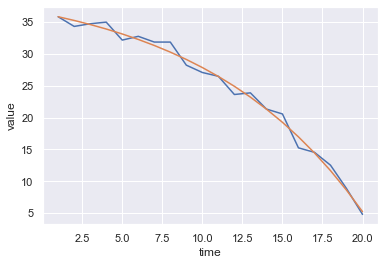

In [17]:
newresults = []
differencemodel(data.value.values[0], newresults, parameters[0], parameters [1], data.shape[0] - 1)
sns.lineplot(data=data, x="time", y="value") 
sns.lineplot(x=data.time, y=newresults)

In [28]:
print(f'Полученные коффициенты l1 = {parameters[0]}, l2 = {parameters[1]}')
print(f'R2 = {r2_score(data.value.values, newresults)}')

Полученные коффициенты l1 = 0.09793042617423196, l2 = 4.0615064499090625
R2 = 0.9909812947320568


In [19]:
CalibrationResults = CalibrationResults.append({'Model': 'Difference', 
                           'Coefficients': f'l1 = {round(parameters[0], 3)}, l2 = {round(parameters[1], 3)}',
                          'R2-score': r2_score(data.value.values, newresults)}, ignore_index=True)


In [20]:
from scipy.integrate import odeint

Разностную модель откалибруем таким же способом. Создадим кастомную функцию `differentialmodel` и будем минимизровать ошибку ее первообразной с помощью `odeint` из библиотеки `scipy.integrate`

In [21]:
def differentialmodel(x, t, k1, k2):
    return k1*x - k2 

In [22]:
def MSE2(parameters):
    k1, k2 = parameters
    results = odeint(differentialmodel, data.value.values[0], data.time.values, args=(k1, k2)).reshape(-1)
    return np.square(np.subtract(results, data.value.values)).mean() 

In [23]:
parameters = [0, 0]
parameters = minimize(MSE2,parameters).x

<AxesSubplot:xlabel='time', ylabel='value'>

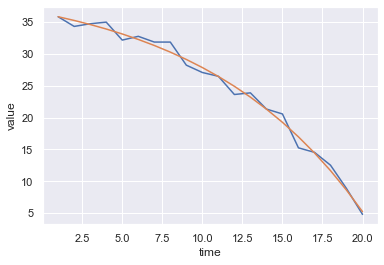

In [24]:
diffy = []
diffy = odeint(differentialmodel, data.value.values[0], data.time.values, args=(parameters[0], parameters[1])).reshape(-1)
sns.lineplot(data=data, x="time", y="value") 
sns.lineplot(x=data.time, y=diffy)

In [25]:
print(f'Полученные коффициенты k1 = {parameters[0]}, k2 = {parameters[1]}')
print(f'R2 = {r2_score(data.value.values, diffy)}')

Полученные коффициенты k1 = 0.09793042617423196, k2 = 4.0615064499090625
R2 = 0.9909812953289131


In [26]:
CalibrationResults = CalibrationResults.append({'Model': 'Differential', 
                           'Coefficients': f'k1 = {round(parameters[0], 3)}, k2 = {round(parameters[1], 3)}',
                          'R2-score': r2_score(data.value.values, diffy)}, ignore_index=True)

In [27]:
CalibrationResults

,Model,Coefficients,R2-score
0,Exponential,"a = -5.107, b = 0.098, c = 41.466",0.990981
1,Difference,"l1 = 1.103, l2 = 4.267",0.990981
2,Differential,"k1 = 0.098, k2 = 4.062",0.990981
